In [1]:
# Husayn El Sharif
comment = """
use PyTorch (use env004)
PyTorch version of eye disease classifier using EfficientNet-B5.

use efficientnet and force 456 x 456 size

make some tweaks to more closely match tensorflow results

tweaks:
do not standardize images using assumed mean and standard deviation. Converting to 0 to 1 range is sufficient

"""

In [2]:
# PyTorch & torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torch.amp import autocast, GradScaler # incorporate AMP for speeding up Pytorch
scaler = GradScaler('cuda', enabled=torch.cuda.is_available())

from torchvision import models, transforms

from torchvision.models import efficientnet_b5, EfficientNet_B5_Weights

In [3]:
# Other imports
import numpy as np
import pandas as pd
import os
import glob
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageOps

from pathlib import Path



In [4]:
# Check for GPU
print("Torch Version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


Torch Version: 2.4.0
CUDA available: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU


device(type='cuda')

In [5]:
# Use filenames and folders to get filepath and labels for all  images
all_imagefiles_list = glob.glob(
    'images/**/*.jpg', 
    recursive=True
)  # resized to 456x456 .jpg earlier

labels_temp = [filepath.split('/')[-2] for filepath in all_imagefiles_list]
patient_id = [f"{Path(filepath).stem.split('_')[0]}_{Path(filepath).parent.name}" for filepath in all_imagefiles_list]

# create dataframe with image_filepath, label
full_data_df = pd.DataFrame({
    'image_filepath': all_imagefiles_list,
    'label': labels_temp,
    'patient_id': patient_id
})

full_data_df

,image_filepath,label,patient_id
0,images/cataract/0_4015166.jpg,cataract,0_cataract
1,images/cataract/0_left.jpg,cataract,0_cataract
2,images/cataract/100_334408.jpg,cataract,100_cataract
3,images/cataract/101_5139882.jpg,cataract,101_cataract
4,images/cataract/101_709333.jpg,cataract,101_cataract
...,...,...,...
4011,images/normal/8_right.jpg,normal,8_normal
4012,images/normal/939_left.jpg,normal,939_normal
4013,images/normal/939_right.jpg,normal,939_normal
4014,images/normal/951_left.jpg,normal,951_normal


In [ ]:
# Split the full data into train, validation, and test sets based on patient_id. 
# Use 80% for training, 10% for validation, and 10% for testing.
# Split by patient_id ensures that images from the same patient do not appear in both training and validation sets or
# training and test sets, or validation and tests sets.
# As eye disease may affect both eyes, this is important to prevent data leakage.

train_ids, not_train_ids = train_test_split(
    full_data_df['patient_id'].unique(), 
    test_size=0.2, 
    random_state=42
)

val_ids, test_ids = train_test_split(
    not_train_ids, 
    test_size=0.5, 
    random_state=42
)


In [7]:
# create dataframes for train, validation, and test sets

train_df = full_data_df[full_data_df['patient_id'].isin(train_ids)].reset_index(drop=True)
val_df = full_data_df[full_data_df['patient_id'].isin(val_ids)].reset_index(drop=True)
test_df = full_data_df[full_data_df['patient_id'].isin(test_ids)].reset_index(drop=True)

In [8]:
# how many images of each label (in training data)?
print(train_df["label"].value_counts())
comment = """
Classes appear roughly balanced in quantity.
"""

label
diabetic_retinopathy    894
normal                  866
cataract                730
glaucoma                730
Name: count, dtype: int64


In [ ]:
# how many images of each label (in validation data)?
print(val_df["label"].value_counts())
comment = """
Classes are reasonably balanced in quantity .
"""

label
normal                  126
diabetic_retinopathy    100
cataract                 88
glaucoma                 80
Name: count, dtype: int64


In [ ]:
# how many images of each label (in test data)?
print(test_df["label"].value_counts())
comment = """
Classes are reasonablybalanced in quantity .
"""

label
cataract                120
diabetic_retinopathy    104
glaucoma                 96
normal                   82
Name: count, dtype: int64


In [ ]:
# Create integer class labels
# Instead of one-hot booleans, we’ll use integer class indices (better for CrossEntropyLoss).

full_data_labels = full_data_df['label'].values.tolist()
unique_labels = sorted(np.unique(full_data_labels))  # e.g. ['cataract', 'diabetic_retinopathy', 'glaucoma', 'normal']

label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}



In [12]:
NUM_CLASSES = len(unique_labels)

In [13]:
# X_train and y_train 
train_labels = train_df['label'].values.tolist()

int_labels = [label_to_idx[label] for label in train_labels]

X_train = train_df["image_filepath"].tolist()
y_train = int_labels

In [14]:
# X_val and y_val 
val_labels = val_df['label'].values.tolist()

int_labels = [label_to_idx[label] for label in val_labels]

X_val = val_df["image_filepath"].tolist()
y_val = int_labels

In [15]:
# X_test and y_test 
test_labels = test_df['label'].values.tolist()

int_labels = [label_to_idx[label] for label in test_labels]

X_test = test_df["image_filepath"].tolist()
y_test = int_labels

In [16]:
len(X_train), len(y_train), len(X_val), len(y_val), len(X_test), len(y_test)


(3220, 3220, 394, 394, 402, 402)

In [17]:
# Dataset & DataLoader with padding + resizing
# pad to square, then resize to 456×456, normalize.

IMG_SIZE_HEIGHT = 456
IMG_SIZE_WIDTH = 456
BATCH_SIZE = 32

def pad_to_square(img: Image.Image, fill=0):
    """
    Pads a PIL image to make it square, centering the original image.
    """
    w, h = img.size
    if w == h:
        return img
    side = max(w, h)
    # Create a new black (or fill) image and paste centered
    new_img = Image.new("RGB", (side, side), color=fill)
    left = (side - w) // 2
    top = (side - h) // 2
    new_img.paste(img, (left, top))
    return new_img

# Transforms (ImageNet-style normalization for EfficientNet)
train_transform = transforms.Compose([
    pad_to_square,
    transforms.Resize((IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH)),
    transforms.ToTensor(),   # converts to [0,1]
])

val_test_transform = transforms.Compose([
    pad_to_square,
    transforms.Resize((IMG_SIZE_HEIGHT, IMG_SIZE_WIDTH)),
    transforms.ToTensor(),
])

In [18]:
# This custom Dataset class loads images from filepaths, applies padding to square, 
# resizing, and any specified transforms.

class EyeDiseaseDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = filepaths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)

        return img, label


In [19]:
# Create datasets
train_dataset = EyeDiseaseDataset(X_train, y_train, transform = train_transform)
val_dataset   = EyeDiseaseDataset(X_val,   y_val,   transform = val_test_transform)
test_dataset  = EyeDiseaseDataset(X_test,  y_test,  transform = val_test_transform)

In [ ]:
# Create dataloaders (handles batching, shuffling, parallel data loading, and provides memory efficiency by loading data into chunks/batches)
# Useful because dataset may be too large to fit into memory all at once.

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


In [21]:
len(train_dataset), len(val_dataset), len(test_dataset)

(3220, 394, 402)

In [22]:
# EfficientNet-B5 model in PyTorch
# We’ll use torchvision.models.efficientnet_b5 and replace the classifier head with a 4-class linear layer.

# Load pre-trained EfficientNet-B5
weights = EfficientNet_B5_Weights.IMAGENET1K_V1
model = efficientnet_b5(weights=weights)

# 1) Freeze the backbone (all layers by default), allows for massive GPU memory savings (not fine-tuning the entire EfficientNet model, and for using a larger batch size)
for param in model.parameters():
    param.requires_grad = False

# Replace classifier head (this stays trainable)
# replace the final classification layer with a new one that outputs a different number of classes (from the original EfficientNet pre-trained model)
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, NUM_CLASSES)

# move model to GPU
model = model.to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [23]:
# Loss, optimizer, simple training loop (with best-model checkpoint)
criterion = nn.CrossEntropyLoss() # typical for multi-class classification
optimizer = optim.Adam(model.classifier[1].parameters(), lr=1e-3) # telling the optimizer to only update the classifier

NUM_EPOCHS = 50 
save_dir = "saved_models_pytorch"
os.makedirs(save_dir, exist_ok=True)
timestamp = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
best_model_path = os.path.join(save_dir, f"best_model_{timestamp}.pth")

best_val_acc = 0.0 # initialization
patience = 6 # increased compared to tensorflow
epochs_no_improve = 0 # intialize counter

In [24]:
# Accuracy calculation function
def accuracy_from_logits(logits, labels):
    preds = torch.argmax(logits, dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    return correct / total

In [ ]:
# to help with GPU memory
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
#os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [26]:
# Training loop with AMP.
# AMP (Automatic Mixed Precision) speeds up training by using lower-precision (float16) computations where possible, 
# while maintaining model accuracy with higher-precision (float32) where necessary.

PRINT_EVERY = 20   # print every 20 batches

for epoch in range(NUM_EPOCHS):
    ################################
    # Train
    ################################
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for batch_idx, (images, labels_batch) in enumerate(train_loader):
        images = images.to(device, non_blocking=True)
        labels_batch = labels_batch.to(device, non_blocking=True)

        optimizer.zero_grad()

        # --- AMP context ---
        with autocast('cuda', enabled=torch.cuda.is_available()):
            outputs = model(images)
            loss = criterion(outputs, labels_batch)

            if batch_idx % PRINT_EVERY == 0:
                print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
                      f"Batch [{batch_idx}/{len(train_loader)}] "
                      f"Loss: {loss.item():.4f}")

        # --- scaled backward + step ---
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * labels_batch.size(0)
        running_correct += (outputs.argmax(1) == labels_batch).sum().item()
        running_total += labels_batch.size(0)

    train_loss = running_loss / running_total
    train_acc = running_correct / running_total

    ################################
    # Validation
    ################################
    model.eval()
    val_loss_sum = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        # you *can* also wrap this in autocast for a bit more speed
        for images, labels_batch in val_loader:
            images = images.to(device, non_blocking=True)
            labels_batch = labels_batch.to(device, non_blocking=True)

            with autocast('cuda', enabled=torch.cuda.is_available()):
                outputs = model(images)
                loss = criterion(outputs, labels_batch)

            val_loss_sum += loss.item() * labels_batch.size(0)
            val_correct += (outputs.argmax(1) == labels_batch).sum().item()
            val_total += labels_batch.size(0)

    val_loss = val_loss_sum / val_total
    val_acc = val_correct / val_total

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Early stopping + best model checkpoint
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
        torch.save({
            'model_state_dict': model.state_dict(),
            'label_to_idx': label_to_idx,
            'idx_to_label': idx_to_label,
            'unique_labels': unique_labels,
        }, best_model_path)
        print(f"  -> New best model saved to {best_model_path}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

Epoch [1/50] Batch [0/101] Loss: 0.5849
Epoch [1/50] Batch [20/101] Loss: 0.5264
Epoch [1/50] Batch [40/101] Loss: 0.5892
Epoch [1/50] Batch [60/101] Loss: 0.4151
Epoch [1/50] Batch [80/101] Loss: 0.5748
Epoch [1/50] Batch [100/101] Loss: 0.4659
Epoch [1/50] Train Loss: 0.5183 Acc: 0.8112 | Val Loss: 0.6425 Acc: 0.7437
  -> New best model saved to saved_models_pytorch/best_model_20260104-072618.pth
Epoch [2/50] Batch [0/101] Loss: 0.3033
Epoch [2/50] Batch [20/101] Loss: 0.3402
Epoch [2/50] Batch [40/101] Loss: 0.5911
Epoch [2/50] Batch [60/101] Loss: 0.5157
Epoch [2/50] Batch [80/101] Loss: 0.4272
Epoch [2/50] Batch [100/101] Loss: 0.5191
Epoch [2/50] Train Loss: 0.4605 Acc: 0.8410 | Val Loss: 0.4511 Acc: 0.8274
  -> New best model saved to saved_models_pytorch/best_model_20260104-072618.pth
Epoch [3/50] Batch [0/101] Loss: 0.3192
Epoch [3/50] Batch [20/101] Loss: 0.5824
Epoch [3/50] Batch [40/101] Loss: 0.2899
Epoch [3/50] Batch [60/101] Loss: 0.4736
Epoch [3/50] Batch [80/101] Loss:

In [27]:
checkpoint = torch.load(best_model_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(device)
model.eval()

idx_to_label = checkpoint['idx_to_label']
unique_labels = checkpoint['unique_labels']
unique_labels

/tmp/ipykernel_18324/2605096054.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_model_path, map_location=device)


[np.str_('cataract'),
 np.str_('diabetic_retinopathy'),
 np.str_('glaucoma'),
 np.str_('normal')]

In [28]:
def evaluate_loader(model, data_loader, idx_to_label_dict):
    model.eval()
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for images, labels_batch in data_loader:
            images = images.to(device, non_blocking=True)
            labels_batch = labels_batch.to(device, non_blocking=True)

            with autocast('cuda', enabled=torch.cuda.is_available()):
                outputs = model(images)

            all_logits.append(outputs.cpu().numpy())
            all_labels.append(labels_batch.cpu().numpy())

    all_logits = np.concatenate(all_logits, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    preds = np.argmax(all_logits, axis=1)

    # Overall metrics
    report = classification_report(
        all_labels, preds, 
        target_names=[idx_to_label_dict[i] for i in range(len(idx_to_label_dict))],
        digits=4
    )
    cm = confusion_matrix(
        [idx_to_label_dict[i] for i in all_labels],
        [idx_to_label_dict[i] for i in preds],
        labels=[idx_to_label_dict[i] for i in range(len(idx_to_label_dict))]
    )

    acc = (preds == all_labels).mean()

    return {
        "logits": all_logits,
        "labels": all_labels,
        "preds": preds,
        "report": report,
        "cm": cm,
        "accuracy": acc,
    }


In [29]:
# Train / Val / Test metrics

train_eval = evaluate_loader(model, train_loader, idx_to_label)
print("Train Accuracy:", train_eval["accuracy"])
print(train_eval["report"])


Train Accuracy: 0.9322981366459627
                      precision    recall  f1-score   support

            cataract     0.9274    0.9630    0.9449       730
diabetic_retinopathy     0.9856    0.9933    0.9894       894
            glaucoma     0.9326    0.8151    0.8699       730
              normal     0.8841    0.9423    0.9122       866

            accuracy                         0.9323      3220
           macro avg     0.9324    0.9284    0.9291      3220
        weighted avg     0.9331    0.9323    0.9315      3220



In [30]:
val_eval = evaluate_loader(model, val_loader, idx_to_label)
print("Validation Accuracy:", val_eval["accuracy"])
print(val_eval["report"])


Validation Accuracy: 0.8883248730964467
                      precision    recall  f1-score   support

            cataract     0.8586    0.9659    0.9091        88
diabetic_retinopathy     0.9796    0.9600    0.9697       100
            glaucoma     0.8667    0.6500    0.7429        80
              normal     0.8540    0.9286    0.8897       126

            accuracy                         0.8883       394
           macro avg     0.8897    0.8761    0.8778       394
        weighted avg     0.8895    0.8883    0.8845       394



In [31]:
test_eval = evaluate_loader(model, test_loader, idx_to_label)
print("Test Accuracy:", test_eval["accuracy"])
print(test_eval["report"])


Test Accuracy: 0.8731343283582089
                      precision    recall  f1-score   support

            cataract     0.8560    0.8917    0.8735       120
diabetic_retinopathy     0.9619    0.9712    0.9665       104
            glaucoma     0.8837    0.7917    0.8352        96
              normal     0.7791    0.8171    0.7976        82

            accuracy                         0.8731       402
           macro avg     0.8702    0.8679    0.8682       402
        weighted avg     0.8743    0.8731    0.8729       402



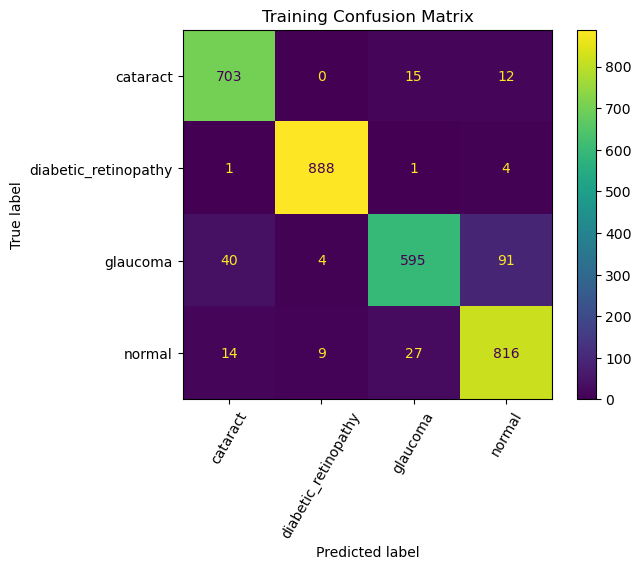

In [32]:
# Training Confusion Matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=train_eval["cm"], 
    display_labels=unique_labels
)
disp.plot(xticks_rotation=60)
plt.title("Training Confusion Matrix")
plt.show()


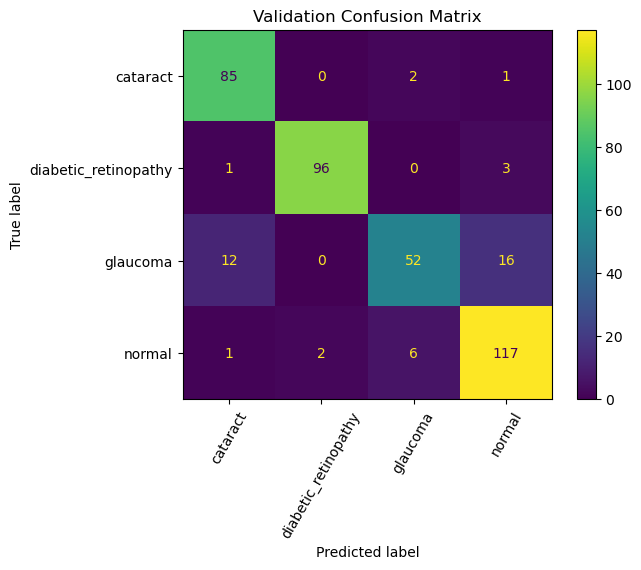

In [33]:
# Validation Confusion Matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=val_eval["cm"], 
    display_labels=unique_labels
)
disp.plot(xticks_rotation=60)
plt.title("Validation Confusion Matrix")
plt.show()


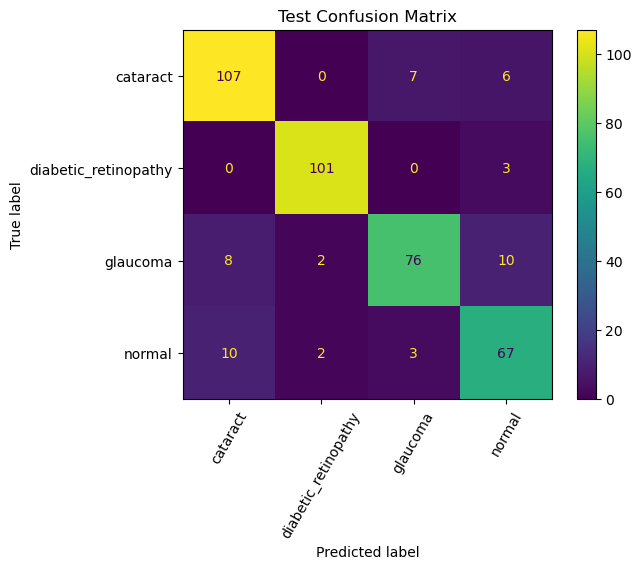

In [34]:
# Test Confusion Matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=test_eval["cm"], 
    display_labels=unique_labels
)
disp.plot(xticks_rotation=60)
plt.title("Test Confusion Matrix")
plt.show()


In [35]:
# Result DataFrames

def collect_results_df(model, data_loader, idx_to_label_dict):
    model.eval()
    all_images = []
    all_true_labels_idx = []
    all_pred_labels_idx = []

    with torch.no_grad():
        for images, labels_batch in data_loader:
            outputs = model(images.to(device))
            preds = outputs.argmax(1).cpu().numpy()

            # store images as numpy arrays in [0, 1] for visualization
            images_np = images.clone()
            images_np = images_np.clamp(0.0, 1.0)

            for img_t, true_idx, pred_idx in zip(
                images_np, labels_batch, preds
            ):
                img_hw3 = img_t.permute(1, 2, 0).cpu().numpy()  # (H,W,3)
                all_images.append(img_hw3)
                all_true_labels_idx.append(int(true_idx))
                all_pred_labels_idx.append(int(pred_idx))

    df = pd.DataFrame({
        "True_Label": [idx_to_label_dict[i] for i in all_true_labels_idx],
        "Prediction_Label": [idx_to_label_dict[i] for i in all_pred_labels_idx],
        "Image_Data": all_images,
    })
    return df


In [36]:
Train_Results_df = collect_results_df(model, train_loader, idx_to_label)
Validation_Results_df = collect_results_df(model, val_loader, idx_to_label)
Test_Results_df = collect_results_df(model, test_loader, idx_to_label)

In [37]:
Train_Results_df[['True_Label', 'Prediction_Label']]

,True_Label,Prediction_Label
0,normal,normal
1,normal,normal
2,normal,normal
3,diabetic_retinopathy,diabetic_retinopathy
4,normal,normal
...,...,...
3215,cataract,cataract
3216,cataract,cataract
3217,glaucoma,glaucoma
3218,diabetic_retinopathy,diabetic_retinopathy


In [38]:
Validation_Results_df[['True_Label', 'Prediction_Label']]

,True_Label,Prediction_Label
0,cataract,cataract
1,cataract,cataract
2,cataract,cataract
3,cataract,cataract
4,cataract,cataract
...,...,...
389,normal,normal
390,normal,normal
391,normal,normal
392,normal,normal


In [39]:
Test_Results_df[['True_Label', 'Prediction_Label']]

,True_Label,Prediction_Label
0,cataract,cataract
1,cataract,cataract
2,cataract,cataract
3,cataract,cataract
4,cataract,normal
...,...,...
397,normal,normal
398,normal,normal
399,normal,cataract
400,normal,normal


In [40]:
# Figure

def to_uint8(img):
    arr = np.asarray(img)
    if arr.dtype == np.uint8:
        return arr
    if np.issubdtype(arr.dtype, np.floating) and arr.max() <= 1.0:
        arr = (np.clip(arr, 0.0, 1.0) * 255).astype(np.uint8)
    else:
        arr = np.clip(arr, 0, 255).astype(np.uint8)
    return arr


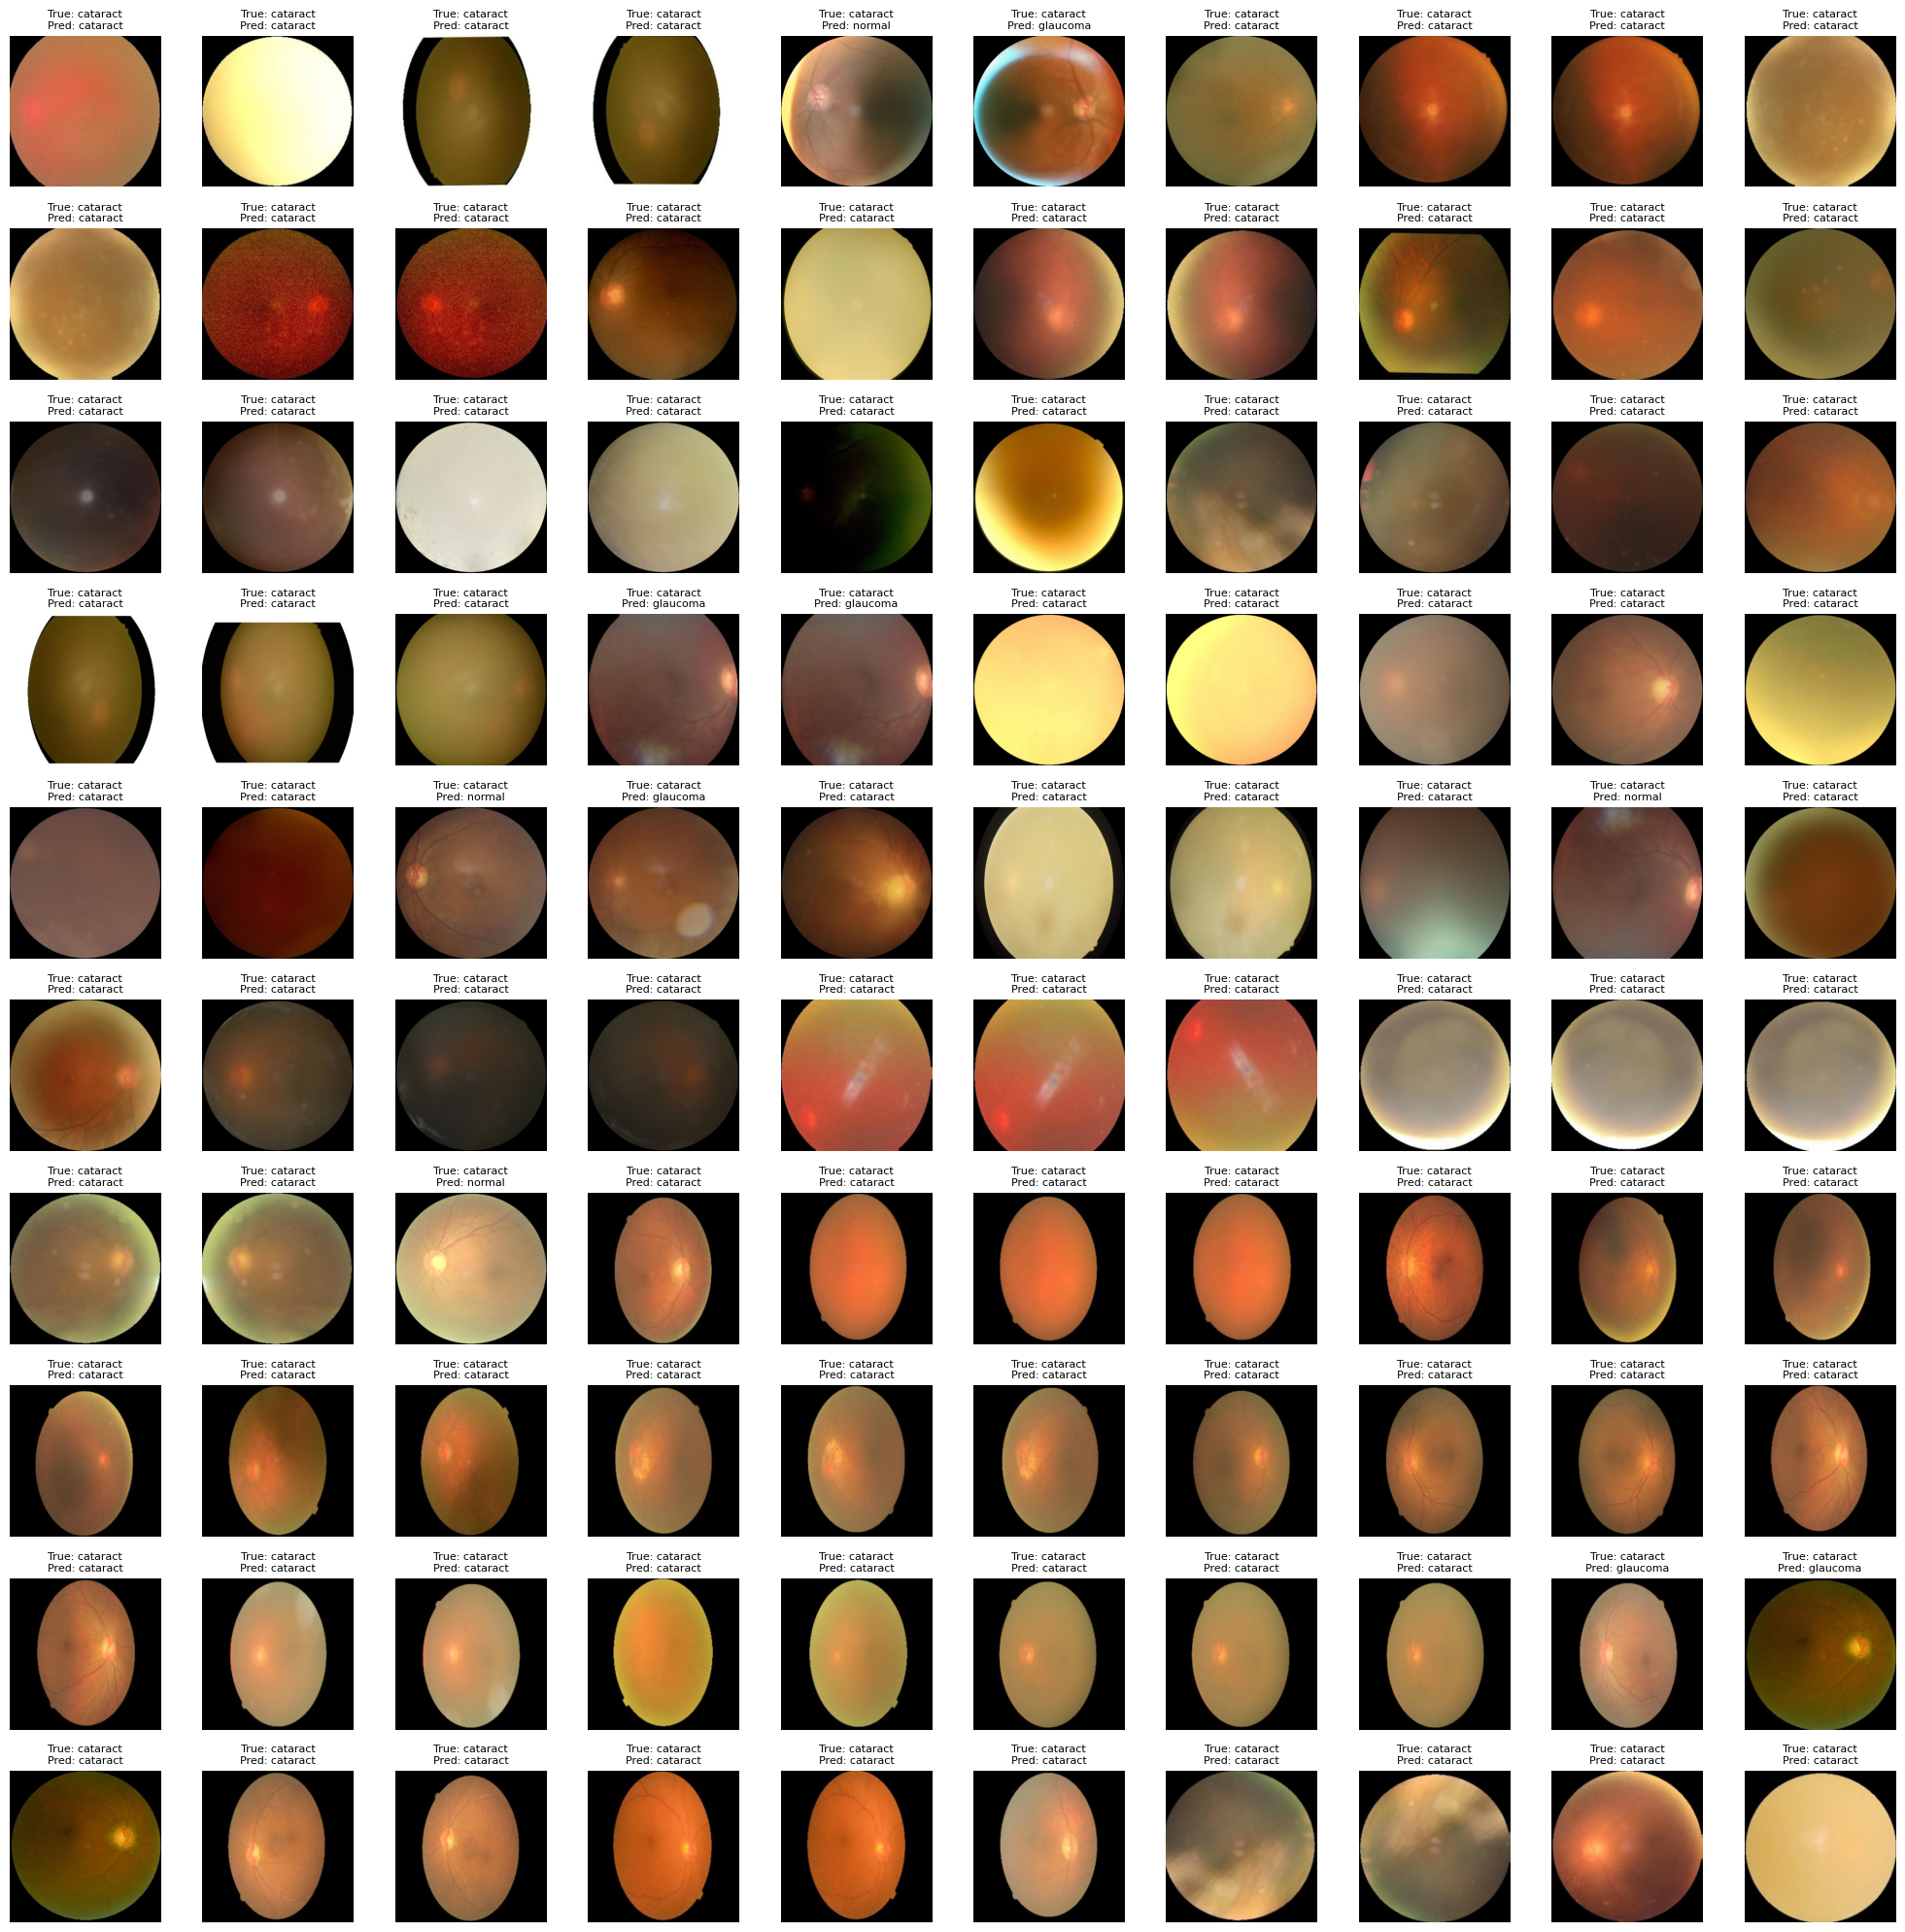

In [41]:
df = Test_Results_df.head(100)
n = len(df)
grid = int(np.ceil(np.sqrt(n)))

fig, axes = plt.subplots(grid, grid, figsize=(grid * 2, grid * 2))
axes = axes.flatten()

for idx, (_, row) in enumerate(df.iterrows()):
    ax = axes[idx]
    img = to_uint8(row["Image_Data"])
    ax.imshow(img)
    ax.set_title(
        f"True: {row['True_Label']}\nPred: {row['Prediction_Label']}",
        fontsize=8
    )
    ax.axis("off")

# Hide extra subplots
for j in range(idx + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [43]:
# Write a csv file of test_df with predictions
test_results_output_df = test_df.copy()
test_results_output_df['Predicted_Label'] = Test_Results_df['Prediction_Label'].values.tolist()
output_csv_path = f"test_results_with_predictions_pytorch_{timestamp}.csv"
test_results_output_df.to_csv(output_csv_path, index=False)
print(f"Test results with predictions saved to {output_csv_path}")

Test results with predictions saved to test_results_with_predictions_pytorch_20260104-072618.csv


In [44]:
test_results_output_df

,image_filepath,label,patient_id,Predicted_Label
0,images/cataract/111_9826667.jpg,cataract,111_cataract,cataract
1,images/cataract/118_6296686.jpg,cataract,118_cataract,cataract
2,images/cataract/130_3561448.jpg,cataract,130_cataract,cataract
3,images/cataract/130_7837321.jpg,cataract,130_cataract,cataract
4,images/cataract/1415_left.jpg,cataract,1415_cataract,normal
...,...,...,...,...
397,images/normal/3364_right.jpg,normal,3364_normal,normal
398,images/normal/3388_left.jpg,normal,3388_normal,normal
399,images/normal/3388_right.jpg,normal,3388_normal,cataract
400,images/normal/3393_left.jpg,normal,3393_normal,normal
